In [8]:
from abelian import LCA, HomLCA, LCAFunc, voronoi
from math import exp, pi, sqrt
Z = LCA(orders = [0], discrete = [True])
R = LCA(orders = [0], discrete = [False])

# Create the Gaussian function on R^2
function = LCAFunc(lambda x: exp(-pi*sum(j**2 for j in x)), domain = R**2)

# Create an hexagonal sampling homomorphism (lattice on R^2)
phi = HomLCA([[1, 1/2], [0, sqrt(3)/2]], source = Z**2, target = R**2)
phi = phi * (1/7) # Downcale the hexagon
function_sampled = function.pullback(phi)

In [9]:
# Approximate the two dimensional integral of the Gaussian
scaling_factor = phi.A.det()
integral_sum = 0
for element in phi.source.elements_by_maxnorm(list(range(20))):
    integral_sum += function_sampled(element)
print(integral_sum * scaling_factor) # 0.999999997457763

0.999999997457763


In [10]:
# Sample, periodize and take DFT of the Gaussian
phi_p = HomLCA([[10, 0], [0, 10]], source = Z**2, target = Z**2)
periodized = function_sampled.pushforward(phi_p.cokernel())
dual_func = periodized.dft()

# Interpret the output of the DFT on R^2
phi_periodize_ann = phi_p.annihilator()

# Compute a Voronoi transversal function, interpret on R^2
sigma = voronoi(phi.dual(), norm_p=2)
factor = phi_p.A.det() * scaling_factor
total_error = 0
for element in dual_func.domain.elements_by_maxnorm():
    value = dual_func(element)
    coords_on_R = sigma(phi_periodize_ann(element))

    # The Gaussian is invariant under Fourier transformation, so we can
    # compare the error using the analytical expression
    true_val = function(coords_on_R)
    approximated_val = abs(value)
    total_error += abs(true_val - approximated_val*factor)

print(total_error)
assert total_error < 10e-15

176.697048765975


AssertionError: 

In [1]:
# Hexagonal Fourier analysis in 2D
from math import exp, sqrt
import numpy as np
import sympy
from sympy import Matrix

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [31]:
# Import objects , create function on R^n
from abelian import HomLCA , LCA , LCAFunc , voronoi
R = LCA(orders = [0], discrete = [False])
k = 0.33 # Decay of exponential

n = 8

# bump 1
# offset = Matrix([[n/2], [n*sqrt(3)/2]])
# offset = Matrix([[n], [0]])
# offset = Matrix([[n*0.75], [n*sqrt(3)/2*0.5]])
offset = Matrix([[10], [5]])
# squish = Matrix([[1], [0]])
# squish = Matrix([[1.25], [0.75]])
squish = Matrix([[1], [1]])

# bump 2
offset2 = Matrix([[0], [0]])

func_expr = lambda x: exp(-k*sum(x_j**2 for x_j in ((x-offset).multiply_elementwise(squish))))  # + exp(-k*sum(x_j**2 for x_j in (x-offset2)))
func = LCAFunc(func_expr , domain = R**2)

In [32]:
# Create a homomorphism to sample
hexagonal_generators = [[1, 0.5], [0, sqrt(3)/2]]
phi_sample = HomLCA(hexagonal_generators, target = R**2)

# Create a homomorphism to periodize
# n = 4
phi_periodize = HomLCA([[n, 0] , [0, n]])
coker_phi_p = phi_periodize.cokernel()

# Move function from R**2 to Z**2 to Z_n**2
func_sampled = func.pullback(phi_sample)
func_periodized = func_sampled.pushforward(coker_phi_p, 25)

In [121]:
# Move function to dual space , then to T**2
func_dual = func_periodized.dft()
phi_periodize_ann = phi_periodize.annihilator()

# Compute a Voronoi transversal function, interpret on R**2
scaling_factor = phi_sample.det()
sigma = voronoi(phi_sample.dual(), norm_p = 2)

orig_value_arr = np.empty((n*n))
value_arr = np.empty((n*n, 2))
coords_on_R_arr = np.empty((n*n, 2))

for idx, element in enumerate(func_dual.domain.elements_by_maxnorm()):
    value = func_dual(element)*scaling_factor
    coords_on_R = sigma(phi_periodize_ann(element))

    orig_value_arr[idx] = sympy.arg(value)
    value_arr[idx, :] = value.as_real_imag()
    coords_on_R_arr[idx, :] = coords_on_R

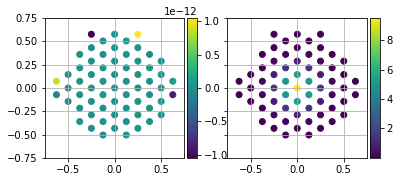

In [5]:
# original, no offsets, no squish, no second bump
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.set_xlim(left=-0.75, right=0.75)
ax1.set_ylim(bottom=-0.75, top=0.75)
ax1.set_aspect('equal', 'box')
sc1 = ax1.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=orig_value_arr, cmap=cm.viridis)
ax1.grid()
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
f.colorbar(sc1, cax=cax1)
ax2.set_aspect('equal', 'box')
sc2 = ax2.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=np.linalg.norm(value_arr, axis=1), cmap=cm.viridis)
ax2.grid()
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
f.colorbar(sc2, cax=cax2)
plt.show()

In [113]:
orig_value_arr3 = np.empty((n*n))
coords_on_R_arr3 = np.empty((n*n, 2))

for idx, element in enumerate(func_periodized.domain.elements_by_maxnorm()):
    value3 = func_periodized(element)
    coords_on_R3 = element

    orig_value_arr3[idx] = value3
    coords_on_R_arr3[idx, :] = coords_on_R3

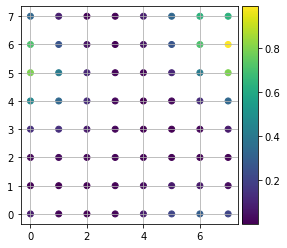

In [101]:
f, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)
# ax1.set_xlim(left=-0.05, right=1.05)
# ax1.set_ylim(bottom=-0.05, top=1.05)
ax1.set_aspect('equal', 'box')
sc1 = ax1.scatter(coords_on_R_arr3[:,0], coords_on_R_arr3[:,1], c=orig_value_arr3, cmap=cm.viridis)
ax1.grid()
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
f.colorbar(sc1, cax=cax1)
plt.show()

In [126]:
# Move function to dual space , then to T**2
gauss = func_dual.idft()
# gauss = tmp6.idft()
phi_periodize_ann2 = phi_periodize.annihilator()

# Compute a Voronoi transversal function, interpret on R**2
scaling_factor2 = phi_sample.det()
sigma2 = phi_sample.dual()

orig_value_arr2 = np.empty((n*n))
coords_on_R_arr2 = np.empty((n*n, 2))

for idx, element in enumerate(gauss.domain.elements_by_maxnorm()):
    value2 = gauss(element)*scaling_factor2
    coords_on_R2 = (phi_periodize_ann2(element))
    coords_on_R2[0] += coords_on_R2[1]*0.5
    if coords_on_R2[0] >= 1.0:
        coords_on_R2[0] -= 1.0  # FIXME: fails if abs(coords_on_R2[0]) >= 2.0
    
    coords_on_R2[1] = sqrt(3)/2 * coords_on_R2[1]

    orig_value_arr2[idx] = value2
    coords_on_R_arr2[idx, :] = coords_on_R2

In [100]:
phi_periodize.kernel()

source: []     target: [Z, Z]
Matrix(2, 0, [])

In [110]:
phi_sample.dual()

source: [R, R]     target: [T, T]
Matrix([[1, 0], [0.500000000000000, 0.866025403784439]])

In [91]:
print(coker_phi_p)
print(coker_phi_p.dual())
print(phi_periodize_ann2)

source: [Z, Z]     target: [Z_8, Z_8]
Matrix([[1, 0], [0, 1]])
source: [Z_8, Z_8]     target: [T, T]
Matrix([[1/8, 0], [0, 1/8]])
source: [Z_8, Z_8]     target: [T, T]
Matrix([[1/8, 0], [0, 1/8]])


In [101]:
coker_phi_p.dual() == phi_periodize_ann2

True

In [82]:
coker_phi_p.dual()([1,6])

[1/8, 3/4]

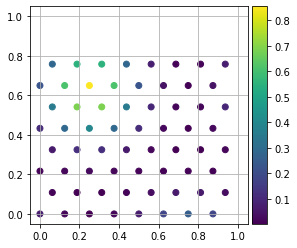

In [21]:
f, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)
ax1.set_xlim(left=-0.05, right=1.05)
ax1.set_ylim(bottom=-0.05, top=1.05)
ax1.set_aspect('equal', 'box')
sc1 = ax1.scatter(coords_on_R_arr2[:,0], coords_on_R_arr2[:,1], c=orig_value_arr2, cmap=cm.viridis)
ax1.grid()
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
f.colorbar(sc1, cax=cax1)
plt.show()

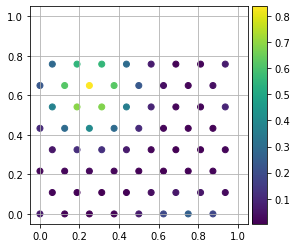

In [127]:
# reconstructed from 5*5 retained frequency components
f, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)
ax1.set_xlim(left=-0.05, right=1.05)
ax1.set_ylim(bottom=-0.05, top=1.05)
ax1.set_aspect('equal', 'box')
sc1 = ax1.scatter(coords_on_R_arr2[:,0], coords_on_R_arr2[:,1], c=orig_value_arr2, cmap=cm.viridis)
ax1.grid()
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
f.colorbar(sc1, cax=cax1)
plt.show()

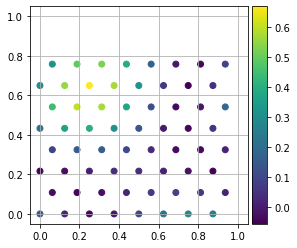

In [123]:
# reconstructed from 3*3 retained frequency components
f, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)
ax1.set_xlim(left=-0.05, right=1.05)
ax1.set_ylim(bottom=-0.05, top=1.05)
ax1.set_aspect('equal', 'box')
sc1 = ax1.scatter(coords_on_R_arr2[:,0], coords_on_R_arr2[:,1], c=orig_value_arr2, cmap=cm.viridis)
ax1.grid()
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
f.colorbar(sc1, cax=cax1)
plt.show()

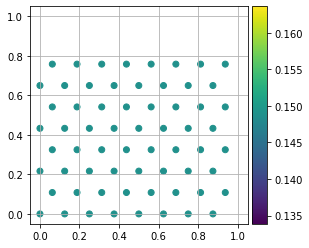

In [115]:
# reconstructed from 1 retained frequency component
f, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)
ax1.set_xlim(left=-0.05, right=1.05)
ax1.set_ylim(bottom=-0.05, top=1.05)
ax1.set_aspect('equal', 'box')
sc1 = ax1.scatter(coords_on_R_arr2[:,0], coords_on_R_arr2[:,1], c=orig_value_arr2, cmap=cm.viridis)
ax1.grid()
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
f.colorbar(sc1, cax=cax1)
plt.show()

In [62]:
# reconstruct via table
domain4 = func_periodized.domain
table4_arr = np.zeros((n, n), dtype=np.complex128)
for index, x in np.ndenumerate(table4_arr):
    table4_arr[index] = gauss([*index])
table4 = table4_arr.tolist()

tmp4 = LCAFunc(table4, domain4)

maxy4 = 0.0
for idx, element in enumerate(func_periodized.domain.elements_by_maxnorm()):
    tmpy = abs(func_periodized(element) - tmp4(element))
    if tmpy > maxy4:
        maxy4 = tmpy

print(maxy4)

1.249000902703301e-16


In [63]:
# crop gauss reconstruction
num_retained_components = 3*3

domain5 = func_periodized.domain
table5_arr = np.zeros((n, n), dtype=np.complex128)
for idx, element in enumerate(func_periodized.domain.elements_by_maxnorm()):
    index = tuple(element)
    print(idx, index)
# for index, x in np.ndenumerate(table5_arr):
    if idx >= num_retained_components:
        break
    table5_arr[index] = gauss([*index])

table5 = table5_arr.tolist()

tmp5 = LCAFunc(table5, domain5)

0 (0, 0)
1 (1, 7)
2 (7, 7)
3 (1, 0)
4 (7, 0)
5 (1, 1)
6 (7, 1)
7 (0, 1)
8 (0, 7)
9 (2, 6)


In [124]:
# crop frequency space reconstruction
num_retained_components = 5*5

domain6 = func_dual.domain
table6_arr = np.zeros((n, n), dtype=np.complex128)
for idx, element in enumerate(func_dual.domain.elements_by_maxnorm()):
    index = tuple(element)
    # print(idx, index)
    # print(abs(func_dual([*index])), func_dual([*index]))
    if idx >= num_retained_components:
        break
    table6_arr[index] = func_dual([*index])

table6 = table6_arr.tolist()

tmp6 = LCAFunc(table6, domain6)

In [125]:
maxy6 = 0.0
for idx, element in enumerate(func_dual.domain.elements_by_maxnorm()):
    tmpy = abs(func_dual(element) - tmp6(element))
    if tmpy > maxy6:
        maxy6 = tmpy

print(maxy6)

0.1402492880838845


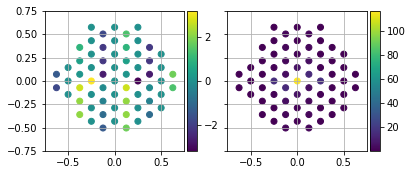

In [90]:
# with Matrix offset n/2,n*sqrt(3)/2
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.set_xlim(left=-0.75, right=0.75)
ax1.set_ylim(bottom=-0.75, top=0.75)
ax1.set_aspect('equal', 'box')
sc1 = ax1.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=orig_value_arr, cmap=cm.viridis)
ax1.grid()
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
f.colorbar(sc1, cax=cax1)
ax2.set_aspect('equal', 'box')
sc2 = ax2.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=np.linalg.norm(value_arr, axis=1), cmap=cm.viridis)
ax2.grid()
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
f.colorbar(sc2, cax=cax2)
plt.show()

In [23]:
coords_on_R_arr

array([[ 0.        ,  0.        ],
       [ 0.125     , -0.21650635],
       [-0.125     , -0.07216878],
       [ 0.125     , -0.07216878],
       [-0.125     ,  0.07216878],
       [ 0.125     ,  0.07216878],
       [-0.125     ,  0.21650635],
       [ 0.        ,  0.14433757],
       [ 0.        , -0.14433757],
       [ 0.25      , -0.4330127 ],
       [-0.25      , -0.14433757],
       [ 0.25      , -0.28867513],
       [-0.25      ,  0.        ],
       [ 0.25      , -0.14433757],
       [-0.25      ,  0.14433757],
       [ 0.25      ,  0.        ],
       [-0.25      ,  0.28867513],
       [ 0.25      ,  0.14433757],
       [-0.25      ,  0.4330127 ],
       [-0.125     ,  0.36084392],
       [-0.125     , -0.21650635],
       [ 0.        ,  0.28867513],
       [ 0.        , -0.28867513],
       [ 0.125     ,  0.21650635],
       [ 0.125     , -0.36084392],
       [-0.625     , -0.07216878],
       [-0.375     , -0.21650635],
       [-0.625     ,  0.07216878],
       [-0.375     ,

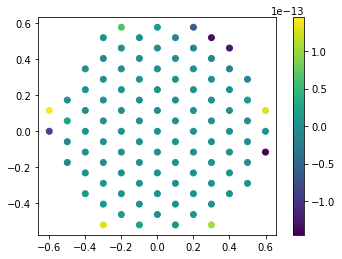

In [160]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.gca().set_aspect('equal')
plt.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=orig_value_arr, cmap=cm.viridis)
plt.colorbar()
plt.show()

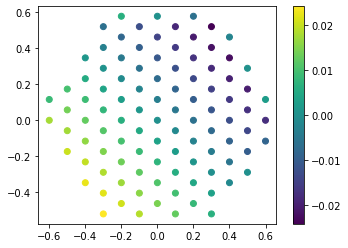

In [176]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# with Matrix offset 0.005,0.005
plt.gca().set_aspect('equal')
plt.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=orig_value_arr, cmap=cm.viridis)
plt.colorbar()
plt.show()

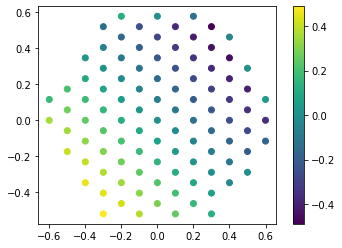

In [168]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# with Matrix offset 0.1,0.1
plt.gca().set_aspect('equal')
plt.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=orig_value_arr, cmap=cm.viridis)
plt.colorbar()
plt.show()

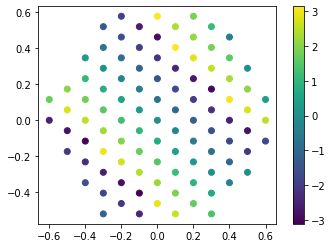

In [164]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# with Matrix offset 1,1
plt.gca().set_aspect('equal')
plt.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=orig_value_arr, cmap=cm.viridis)
plt.colorbar()
plt.show()

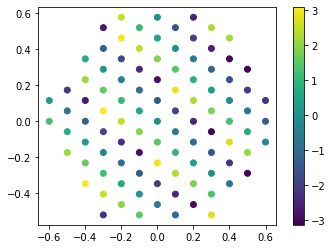

In [180]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# with Matrix offset 2,2
plt.gca().set_aspect('equal')
plt.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=orig_value_arr, cmap=cm.viridis)
plt.colorbar()
plt.show()

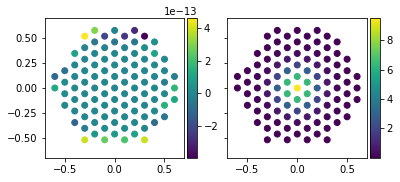

In [206]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# with Matrix offset 5,10*sqrt(3)/2
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.set_xlim(left=-0.7, right=0.7)
ax1.set_ylim(bottom=-0.7, top=0.7)
ax1.set_aspect('equal', 'box')
sc1 = ax1.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=orig_value_arr, cmap=cm.viridis)
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
f.colorbar(sc1, cax=cax1)
ax2.set_aspect('equal', 'box')
sc2 = ax2.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=np.linalg.norm(value_arr, axis=1), cmap=cm.viridis)
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
f.colorbar(sc2, cax=cax2)
plt.show()

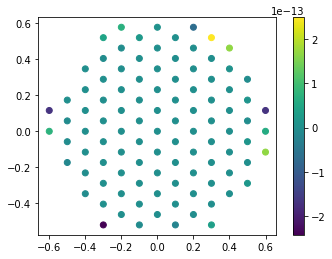

In [188]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# with Matrix offset 10,0
plt.gca().set_aspect('equal')
plt.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=orig_value_arr, cmap=cm.viridis)
plt.colorbar()
plt.show()

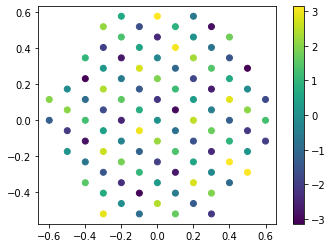

In [156]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# with Matrix offset 3,3
plt.gca().set_aspect('equal')
plt.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=orig_value_arr, cmap=cm.viridis)
plt.colorbar()
plt.show()

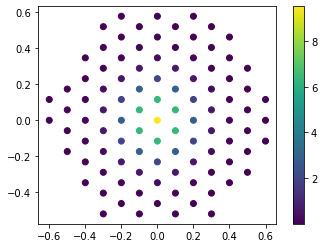

In [104]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.gca().set_aspect('equal')
plt.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=np.linalg.norm(value_arr, axis=1), cmap=cm.viridis)
plt.colorbar()
plt.show()

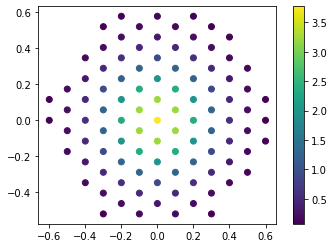

In [34]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# different variance
plt.gca().set_aspect('equal')
plt.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=np.linalg.norm(value_arr, axis=1), cmap=cm.viridis)
plt.colorbar()
plt.show()

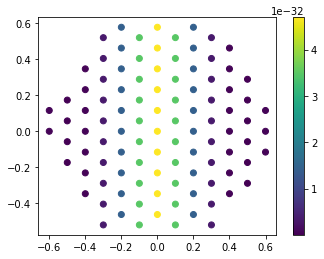

In [50]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# equal offset for each x_j (-40)
plt.gca().set_aspect('equal')
plt.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=np.linalg.norm(value_arr, axis=1), cmap=cm.viridis)
plt.colorbar()
plt.show()

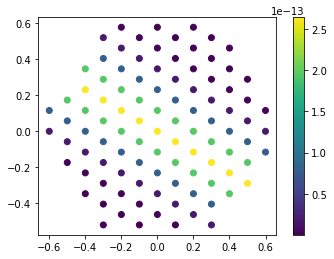

In [68]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Matrix offset 40,0
plt.gca().set_aspect('equal')
plt.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=np.linalg.norm(value_arr, axis=1), cmap=cm.viridis)
plt.colorbar()
plt.show()

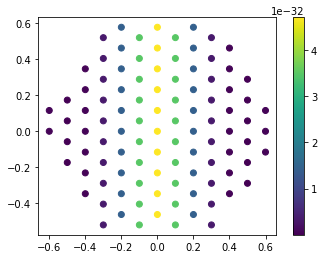

In [72]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Matrix offset 0,40
plt.gca().set_aspect('equal')
plt.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=np.linalg.norm(value_arr, axis=1), cmap=cm.viridis)
plt.colorbar()
plt.show()

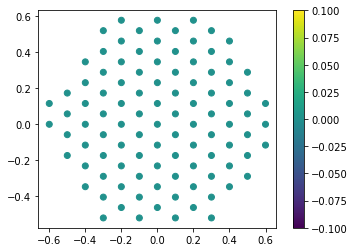

In [76]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Matrix offset 0,80
plt.gca().set_aspect('equal')
plt.scatter(coords_on_R_arr[:,0], coords_on_R_arr[:,1], c=np.linalg.norm(value_arr, axis=1), cmap=cm.viridis)
plt.colorbar()
plt.show()